In [2]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.integrate as integrate
from scipy.stats import uniform
from scipy.stats import norm
from astroquery.gaia import Gaia

In [5]:
# Define some distribution for the priors
# Uniform prior has already built-in scipy.stats.uniform

# Constant Volume Density
class ConstantDensity:
  #max distance
  rmax = 1000

  def __init__(self, rmax=1000):
    self.rmax = rmax

  def pdf(self, x):
    if(isinstance(x, (list, tuple, np.ndarray))):
      return np.array(list(map(self.pdf, x)))
    if(x<0 or x>self.rmax): return 0
    return 3/self.rmax**3*x*x

# Exponentially Decreasing
class ExponentiallyDecreasing:
  # scale length
  rlen = 1000

  def __init__(self, rlen=1000):
    self.rlen = rlen
    
  def pdf(self, x):
    if(isinstance(x, (list, tuple, np.ndarray))):
      return np.array(list(map(self.pdf, x)))
    a = x/self.rlen
    if(x<=0): return 0
    return 1/(2*self.rlen)*a**2*np.exp(-a)

In [6]:
# Grab data from Gaia DR2
job = Gaia.launch_job_async(""" 
SELECT TOP 100 *
FROM gaiadr2.gaia_source
WHERE parallax > 0
""")
r = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


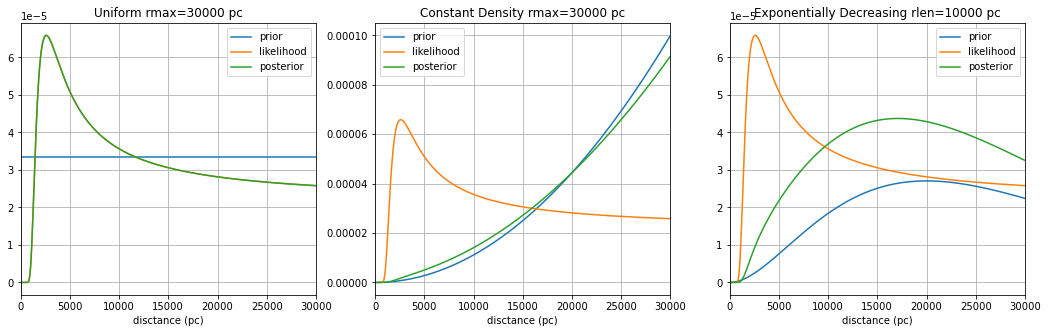

parallax (mas) =  0.38333928615043145
parallax_error (mas) =  0.2556380012067639
f =  0.6668713863740161


In [8]:
# Init Data, just change the index as you like
index = 99
parallax = r["parallax"][index]/1000
parallax_error = r["parallax_error"][index]/1000

# Preliminary 
## Trust me, rmax = 30_000 pc is reasonable
rmax = 3E4
distance = np.linspace(1, rmax, 1000)
## Likelihood function, see Bailer-Jones
likelihood = norm.pdf(x=1/distance, scale=parallax_error, loc=parallax)
normalization, _ = integrate.quad(lambda t: norm.pdf(x=1/t, scale=parallax_error, loc=parallax), a=0, b=rmax)
likelihood /= normalization

# Prior 1, Uniform
prior1 = uniform.pdf(x=distance, scale=rmax)
posterior1 = prior1*likelihood
posterior1_norm = integrate.simps(posterior1, distance)
posterior1 /= posterior1_norm

# Prior 2, Constant Volume Density
dist2 = ConstantDensity(rmax)
prior2 = dist2.pdf(x=distance)
posterior2 = prior2*likelihood
posterior2_norm = integrate.simps(posterior2, distance)
posterior2 /= posterior2_norm

# Prior 3, Exponentially Decreasing
## scale length 10_000, seem reasonable
rlen = 1E4
dist3 = ExponentiallyDecreasing(rlen)
prior3 = dist3.pdf(x=distance)
posterior3 = prior3*likelihood
posterior3_norm = integrate.simps(posterior3, distance)
posterior3 /= posterior3_norm

# Plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))

ax1.plot(distance, prior1, label="prior")
ax1.plot(distance, likelihood, label="likelihood")
ax1.plot(distance, posterior1, label="posterior")
ax1.legend(loc="best")
ax1.grid()
ax1.set_xlim(0, rmax)
ax1.set_xlabel("disctance (pc)")
ax1.set_title(f"Uniform rmax={int(rmax)} pc")

ax2.plot(distance, prior2, label="prior")
ax2.plot(distance, likelihood, label="likelihood")
ax2.plot(distance, posterior2, label="posterior")
ax2.legend(loc="best")
ax2.grid()
ax2.set_xlim(0, rmax)
ax2.set_xlabel("disctance (pc)")
ax2.set_title(f"Constant Density rmax={int(rmax)} pc")

ax3.plot(distance, prior3, label="prior")
ax3.plot(distance, likelihood, label="likelihood")
ax3.plot(distance, posterior3, label="posterior")
ax3.legend(loc="best")
ax3.grid()
ax3.set_xlim(0, rmax)
ax3.set_xlabel("disctance (pc)")
ax3.set_title(f"Exponentially Decreasing rlen={int(rlen)} pc")

plt.show()

## Print the data that being used
print("parallax (mas) = ", parallax*1000)
print("parallax_error (mas) = ", parallax_error*1000)
print("f = ", parallax_error/parallax)